In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from save_experiment import save_experiment
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv('../processed_data/hp_energy_production_with_engineered_features_1.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna()
df = df[df['Station'] == 'Amberd2']

features = [
    'Water_Flow_m3_s', 'avgtempC', 'totalprecipMM', 'humidity', 'pressureMB',
    'Month', 'WaterFlow_Diff_1d', 'WaterFlow_Diff_7d', 'WaterFlow_3day_avg',
    'WaterFlow_7day_avg', 'Temp_Deviation', 'WaterFlow_Humidity',
    'month_sin', 'month_cos', 'Prev_Day_Efficiency', 'Prev_Week_Efficiency'
]
target = 'Normalized_Efficiency'

In [3]:
df_num = df.select_dtypes(include=['number']).dropna()
X = df_num.drop(columns=['Normalized_Efficiency'])
y = df_num['Normalized_Efficiency']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(n_estimators=500, depth=10, learning_rate=0.05, random_state=42, verbose=0),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=10),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "Multiple Linear Regression (MLR)": LinearRegression(),
    "SVR": SVR()
}

In [5]:
results = {}

for name, model in tqdm(models.items()):
    if name in ['MLP Regressor']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Prediction': y_pred
    }

/Users/elvinanosrati/Capstone/energy-production-analysis/myenv-py311/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.12731e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.28it/s]


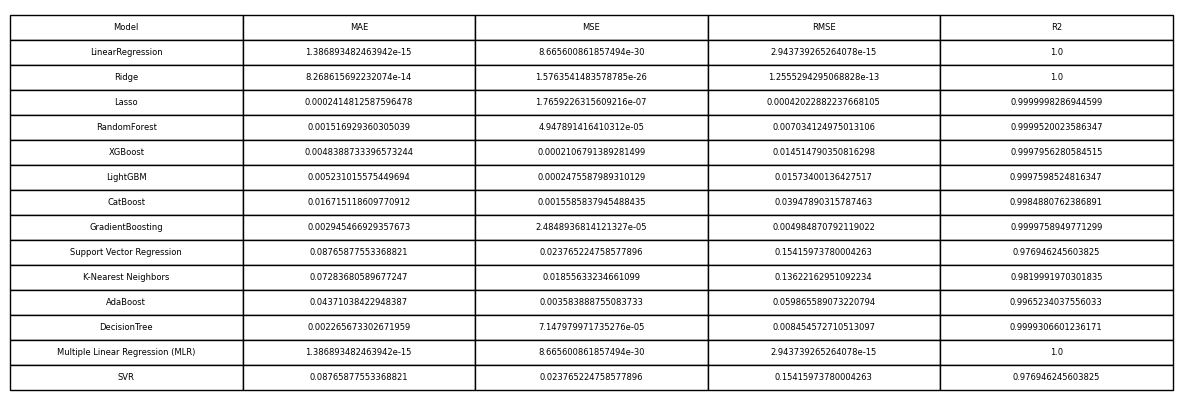

In [6]:
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['MAE'] for m in results],
    'MSE': [results[m]['MSE'] for m in results],
    'RMSE': [results[m]['RMSE'] for m in results],
    'R2': [results[m]['R2'] for m in results]
})

fig, ax = plt.subplots(figsize=(10,5))
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(1.5, 1.5)
plt.show()

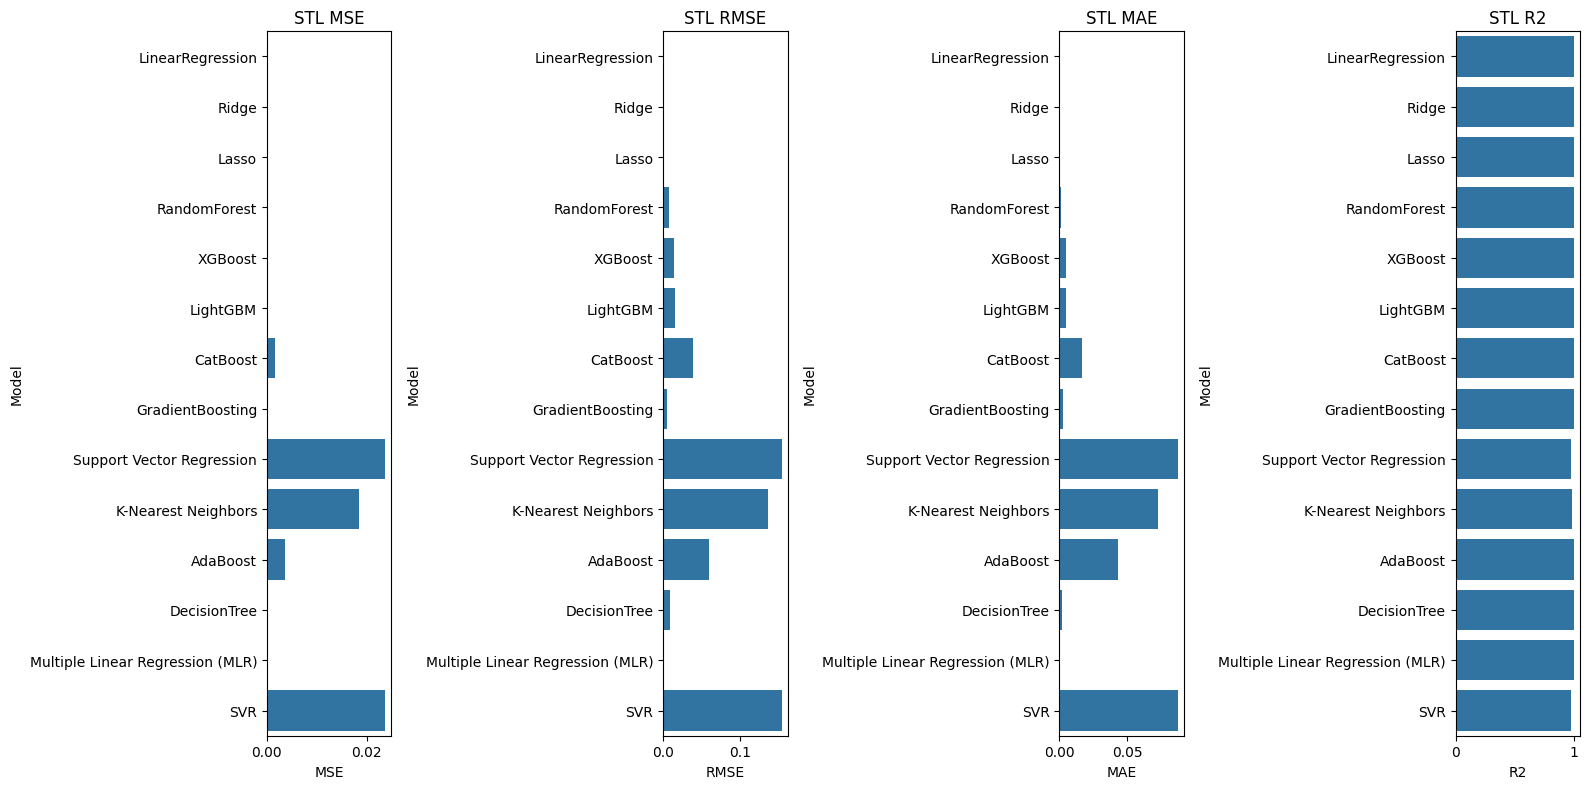

In [7]:
plt.figure(figsize=(16, 8))
for i, metric in enumerate(["MSE", "RMSE", "MAE", "R2"]):
    plt.subplot(1, 4, i + 1)
    sns.barplot(y="Model", x=metric, data=metrics_df)
    plt.title("STL " + metric)
    plt.tight_layout()
plt.show()

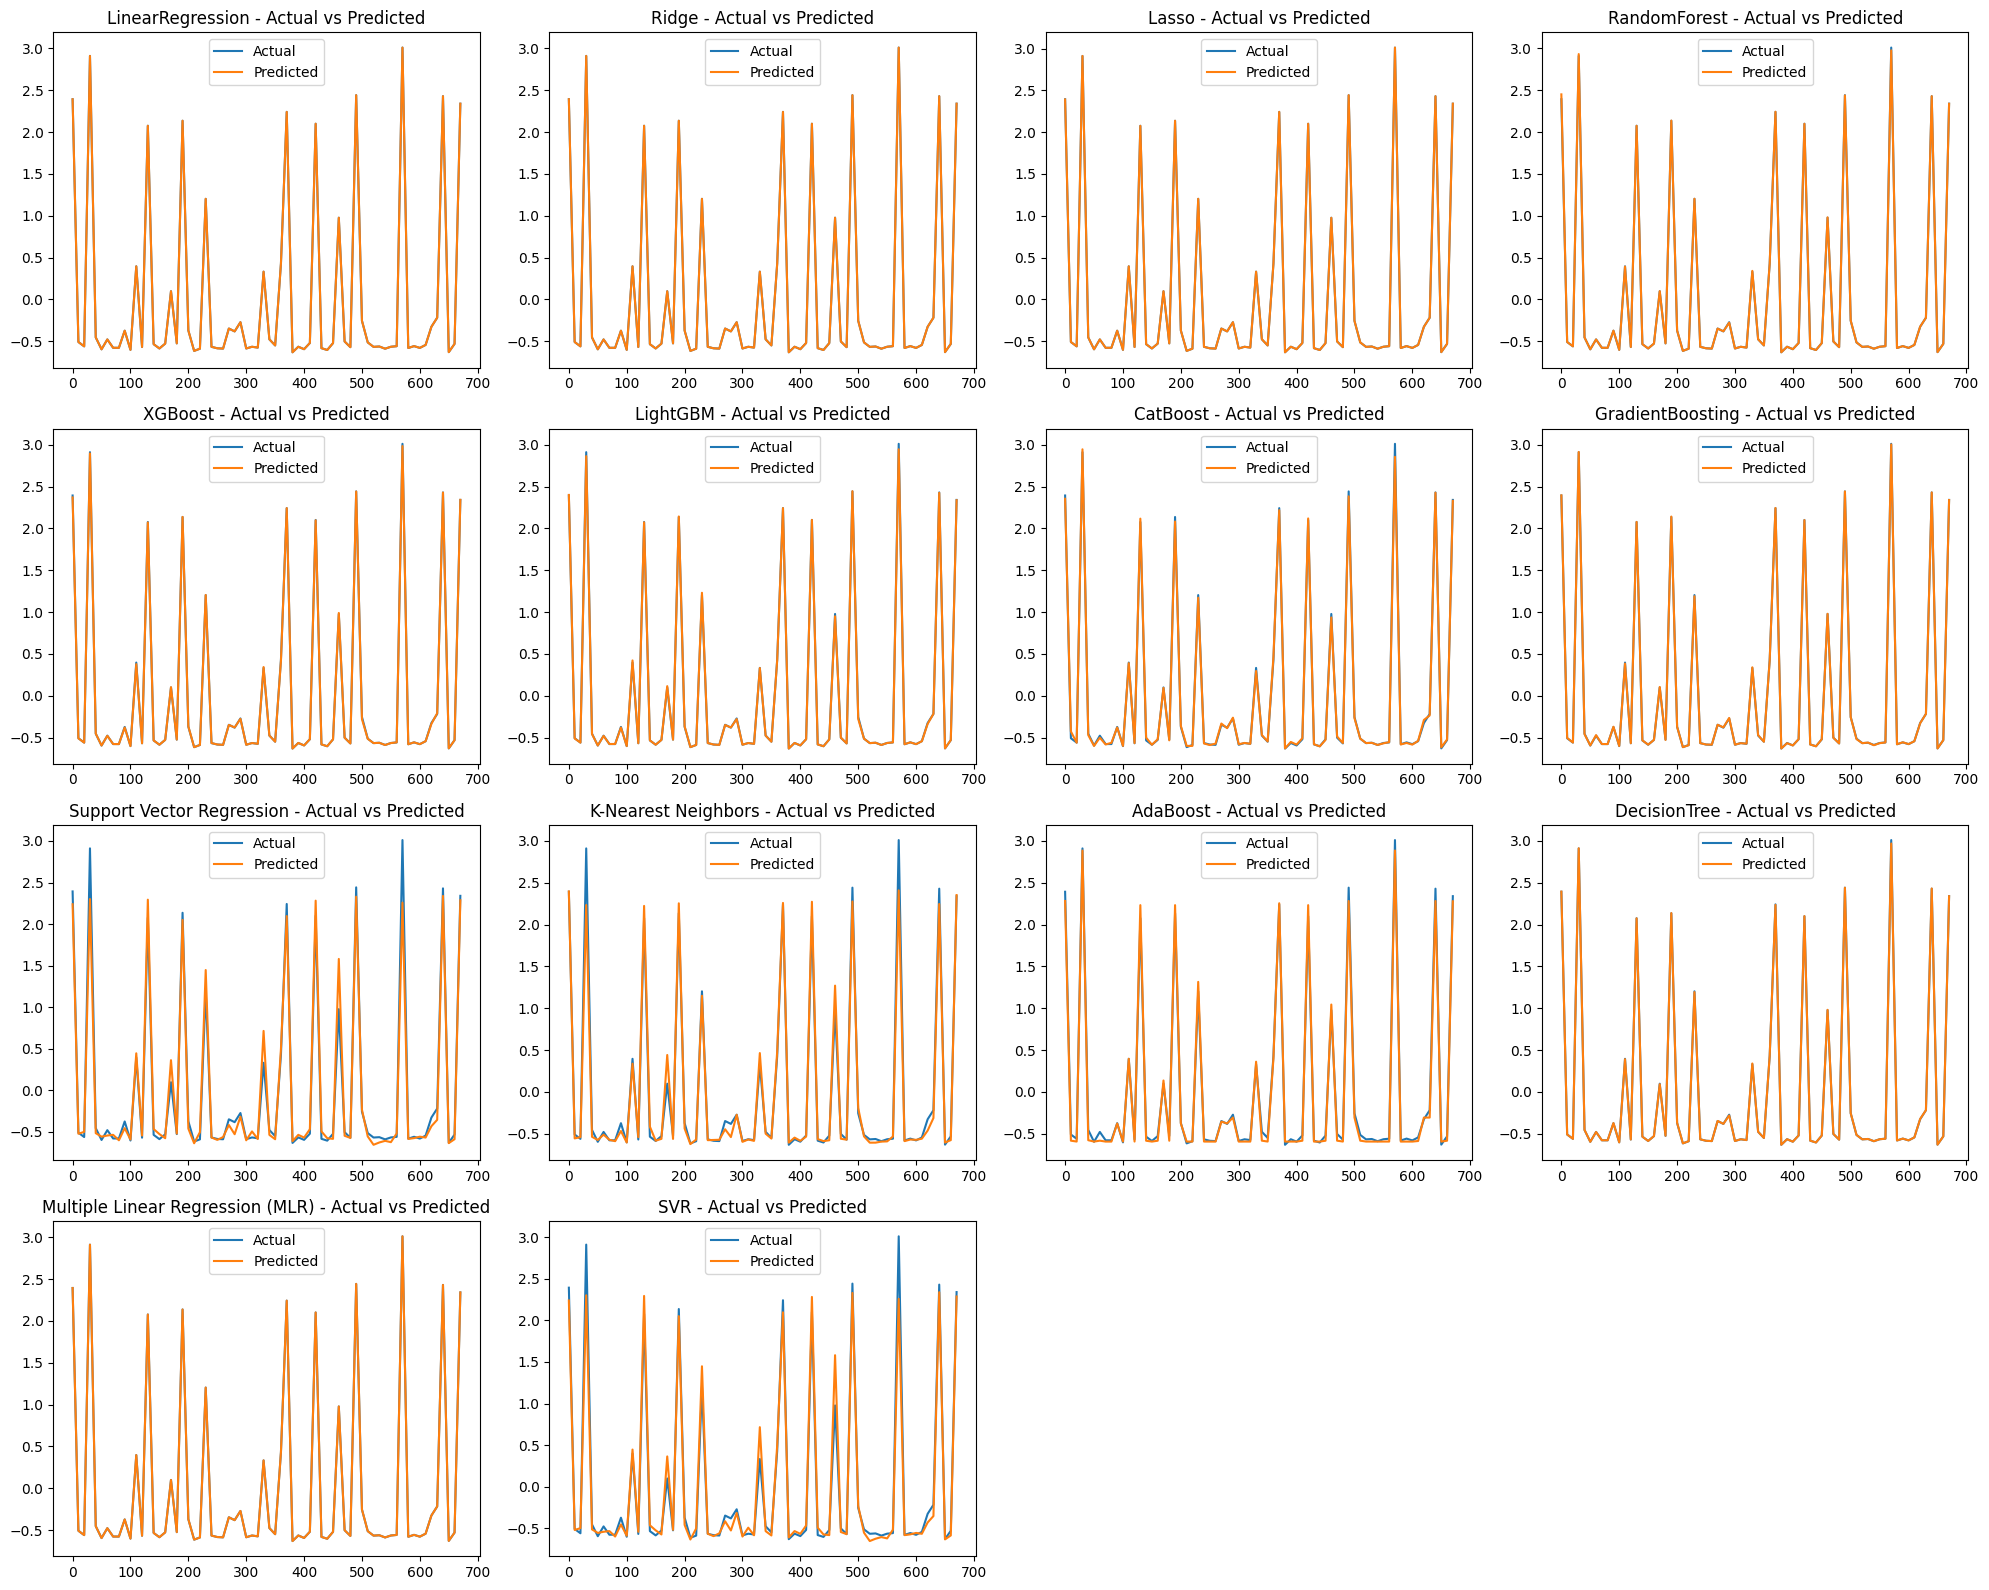

In [8]:
cols_stl      = 4
num_models_stl = len(results)
rows_stl      = int(np.ceil(num_models_stl / cols_stl))

idx = np.arange(len(y_test))[::10]

plt.figure(figsize=(20, 16))
for i, (name, res) in enumerate(results.items()):
    ax = plt.subplot(rows_stl, cols_stl, i + 1)
    ax.plot(idx, y_test.values[idx],        label='Actual')
    ax.plot(idx, res['Prediction'][idx],    label='Predicted')
    ax.set_title(f"{name} - Actual vs Predicted")
    ax.legend()
plt.tight_layout()
plt.show()

In [9]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

X_train_tensor           = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor            = torch.tensor(X_test_scaled,  dtype=torch.float32)
X_train_tensor_tabular = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor_tabular  = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_train_tensor           = torch.tensor(y_train.values,    dtype=torch.float32).view(-1, 1)
y_test_tensor            = torch.tensor(y_test.values,     dtype=torch.float32).view(-1, 1)

train_dataset            = TensorDataset(X_train_tensor,        y_train_tensor)
test_dataset             = TensorDataset(X_test_tensor,         y_test_tensor)  

train_dataset_tabular    = TensorDataset(X_train_tensor_tabular, y_train_tensor)
test_dataset_tabular     = TensorDataset(X_test_tensor_tabular,  y_test_tensor)

train_loader             = DataLoader(train_dataset,          batch_size=64,  shuffle=True)
test_loader              = DataLoader(test_dataset,           batch_size=64,  shuffle=False)
train_loader_tabular     = DataLoader(train_dataset_tabular,  batch_size=256, shuffle=True)
test_loader_tabular      = DataLoader(test_dataset_tabular,   batch_size=256, shuffle=False)

In [29]:
def reshape_input(model, xb):
    rnn_models = (LSTMNet, BiLSTMNet, RNNNet, GRUNet, CNNLSTM, DeepLSTMNet, Seq2SeqLSTM, CNNBiLSTM, GRUCNN)
    cnn_models = (CNN1D, CNNLSTM, CNNBiLSTM, GRUCNN)
    tcn_models = (TCN, TCNLSTM)

    if isinstance(model, tcn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(-1)
            xb = xb.transpose(1, 2)
    elif isinstance(model, rnn_models + cnn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(1)
    return xb

In [10]:
class Net1(nn.Module):
    def __init__(self, input_dim):
        super(Net1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net2(nn.Module):
    def __init__(self, input_dim):
        super(Net2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net3(nn.Module):
    def __init__(self, input_dim):
        super(Net3, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

class Net4(nn.Module):
    def __init__(self, input_dim):
        super(Net4, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [11]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class BiLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(BiLSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class RNNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(RNNNet, self).__init__()
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])


class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

class CNN1D(nn.Module):
    def __init__(self, input_dim, num_filters, num_layers, kernel_size, dropout):
        super().__init__()
        layers = []
        in_ch = input_dim
        for _ in range(num_layers):
            layers += [
                nn.Conv1d(in_ch, num_filters, kernel_size, padding=kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = num_filters
        self.features = nn.Sequential(*layers)
        self.fc = nn.Linear(num_filters, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        out = self.features(x)
        out = out.mean(dim=2)
        return self.fc(out)


class CNNLSTM(nn.Module):
    def __init__(
        self,
        input_dim: int,
        cnn_filters: list[int] = [64, 64],
        cnn_kernel_size: int = 3,
        lstm_hidden: int = 128,
        lstm_layers: int = 2,
        dropout: float = 0.3
    ):
        super().__init__()
        if isinstance(cnn_filters, int):
            cnn_filters = [cnn_filters]
        convs, in_ch = [], 1
        for out_ch in cnn_filters:
            convs += [
                nn.Conv1d(in_ch, out_ch, kernel_size=cnn_kernel_size,
                          padding=cnn_kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = out_ch
        self.cnn = nn.Sequential(*convs)
        self.lstm = nn.LSTM(
            input_size=in_ch,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )
        self.head = nn.Linear(lstm_hidden, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 4:
            x = x.squeeze(1)

        if x.dim() == 2:
            b, f = x.shape
            x = x.unsqueeze(1)       
            x = self.cnn(x)          
            x = x.transpose(1, 2)     
            out, _ = self.lstm(x)     
            return self.head(out[:, -1, :])

        elif x.dim() == 3:
            b, s, f = x.shape
            x = x.reshape(b * s, f).unsqueeze(1)  
            x = self.cnn(x)                      
            x = x.mean(dim=2)                     
            x = x.view(b, s, -1)                  
            out, _ = self.lstm(x)                 
            return self.head(out[:, -1, :])

        else:
            raise ValueError(f"Unsupported input dims: {x.dim()}")


class FNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

class DeepFNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

class DeepLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=4, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)

        self.downsample = (nn.Conv1d(in_channels, out_channels, 1)
                           if in_channels != out_channels else None)
        self.relu = nn.ReLU()

    def forward(self, x):
        L = x.size(2) 
        out = self.conv1(x)[..., :L]    
        out = self.bn1(out); out = self.relu(out); out = self.dropout1(out)

        out = self.conv2(out)[..., :L]
        out = self.bn2(out); out = self.relu(out); out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2

        self.conv1 = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn1      = nn.BatchNorm1d(out_channels)
        self.relu1    = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(
            out_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn2      = nn.BatchNorm1d(out_channels)
        self.relu2    = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = (
            nn.Conv1d(in_channels, out_channels, 1)
            if in_channels != out_channels else None
        )
        self.final_relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.final_relu(out + res)


class TCN(nn.Module):
    def __init__(self, input_dim, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i, out_ch in enumerate(num_channels):
            in_ch   = input_dim if i == 0 else num_channels[i-1]
            dilation = 2 ** i
            layers.append(
                TemporalBlock(
                    in_channels=in_ch,
                    out_channels=out_ch,
                    kernel_size=kernel_size,
                    stride=1,
                    dilation=dilation,
                    dropout=dropout
                )
            )
        self.network = nn.Sequential(*layers)
        self.fc      = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        x = x.transpose(1, 2)     
        y = self.network(x)       
        y = y[:, :, -1]           
        return self.fc(y)    

class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, cnn_filters=32, lstm_hidden=64, lstm_layers=2, dropout=0.3):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, cnn_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bilstm = nn.LSTM(
            input_size=cnn_filters,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.fc = nn.Linear(2 * lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.cnn(x)
        x = x.transpose(1, 2)
        out, _ = self.bilstm(x)
        return self.fc(out[:, -1, :])

class GRUCNN(nn.Module):
    def __init__(self, input_dim, gru_hidden=64, cnn_filters=32, kernel_size=3, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, gru_hidden, batch_first=True)
        self.cnn = nn.Sequential(
            nn.Conv1d(gru_hidden, cnn_filters, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.fc = nn.Linear(cnn_filters, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.cnn(out.transpose(1, 2))
        out = out.mean(dim=2)
        return self.fc(out)

class TCNLSTM(nn.Module):
    def __init__(self, input_dim, tcn_channels=[64,64], lstm_hidden=64, lstm_layers=1, kernel_size=3, dropout=0.3):
        super().__init__()
        self.tcn = TCN(input_dim, tcn_channels, kernel_size=kernel_size, dropout=dropout)
        self.lstm = nn.LSTM(input_size=tcn_channels[-1], hidden_size=lstm_hidden, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.tcn.network(x).transpose(1, 2)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (hidden, cell) = self.encoder(x)
        dec_input = torch.zeros(x.size(0), 1, hidden.size(2)).to(x.device)
        out, _ = self.decoder(dec_input, (hidden, cell))
        return self.fc(out[:, -1, :])
  

In [12]:
def train_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,epochs=1000, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    history = []
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                y_train_pred = model(X_train_tensor)
                y_test_pred  = model(X_test_tensor)
                
                train_mse  = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mse   = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_rmse = np.sqrt(train_mse)
                test_rmse  = np.sqrt(test_mse)
                train_mae  = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mae   = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_r2   = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
                test_r2    = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())
                
                print(f"\nModel: {name} | Epoch: {epoch}")
                print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
                print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
                
                history.append({
                    "Model": name,
                    "Epoch": epoch,
                    "Train MSE": train_mse,
                    "Test MSE": test_mse,
                    "Train RMSE": train_rmse,
                    "Test RMSE": test_rmse,
                    "Train MAE": train_mae,
                    "Test MAE": test_mae,
                    "Train R2": train_r2,
                    "Test R2": test_r2
                })
    return history

In [13]:
def train_ts_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=200, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    history = []
    for epoch in tqdm(range(1, epochs + 1), desc=f"Training {name}"):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()    
            running_loss += loss.item()

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                y_train_pred = model(X_train_tensor)
                y_test_pred  = model(X_test_tensor)

                train_mse = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mse  = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_rmse = np.sqrt(train_mse)
                test_rmse  = np.sqrt(test_mse)
                train_mae = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mae  = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_r2  = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
                test_r2   = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())

                history.append({
                    "Model": name,
                    "Epoch": epoch,
                    "Train MSE": train_mse,
                    "Test MSE": test_mse,
                    "Train RMSE": train_rmse,
                    "Test RMSE": test_rmse,
                    "Train MAE": train_mae,
                    "Test MAE": test_mae,
                    "Train R2": train_r2,
                    "Test R2": test_r2
                })
        
        if epoch % 100 == 0:
            print(f"\nModel: {name} | Epoch: {epoch}")
            print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
            print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

    return history


In [14]:
nets = {
    "Net1":   Net1(X.shape[1]),
    "Net2":   Net2(X.shape[1]),
    "Net3":   Net3(X.shape[1]),
    "Net4":   Net4(X.shape[1])
}

nets_tabular = {
    "Net1":    Net1(X.shape[1]),
    "Net2":    Net2(X.shape[1]),
    "Net3":    Net3(X.shape[1]),
    "Net4":    Net4(X.shape[1]),
    "FNN":     FNN(X.shape[1]),
    "DeepFNN": DeepFNN(X.shape[1])
}

In [15]:
results = []
for name, net in nets.items():
    results += train_model(name, net, train_loader, 
                               X_train_tensor, y_train_tensor, 
                               X_test_tensor, y_test_tensor,
                               epochs=100, lr=1e-3)
    
nn_metrics_df = pd.DataFrame(results)

 17%|█████████████████▎                                                                                    | 17/100 [00:00<00:02, 32.85it/s]


Model: Net1 | Epoch: 10
Train: MSE: 0.0011, RMSE: 0.0337, MAE: 0.0253, R2: 0.9989
Test:  MSE: 0.0014, RMSE: 0.0375, MAE: 0.0280, R2: 0.9986


 25%|█████████████████████████▌                                                                            | 25/100 [00:00<00:02, 34.12it/s]


Model: Net1 | Epoch: 20
Train: MSE: 0.0004, RMSE: 0.0208, MAE: 0.0155, R2: 0.9996
Test:  MSE: 0.0006, RMSE: 0.0246, MAE: 0.0180, R2: 0.9994


 33%|█████████████████████████████████▋                                                                    | 33/100 [00:01<00:01, 34.46it/s]


Model: Net1 | Epoch: 30
Train: MSE: 0.0003, RMSE: 0.0170, MAE: 0.0127, R2: 0.9997
Test:  MSE: 0.0004, RMSE: 0.0208, MAE: 0.0150, R2: 0.9996


 45%|█████████████████████████████████████████████▉                                                        | 45/100 [00:01<00:01, 29.04it/s]


Model: Net1 | Epoch: 40
Train: MSE: 0.0002, RMSE: 0.0145, MAE: 0.0108, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0184, MAE: 0.0132, R2: 0.9997


 53%|██████████████████████████████████████████████████████                                                | 53/100 [00:01<00:01, 31.02it/s]


Model: Net1 | Epoch: 50
Train: MSE: 0.0002, RMSE: 0.0132, MAE: 0.0101, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0172, MAE: 0.0124, R2: 0.9997


 65%|██████████████████████████████████████████████████████████████████▎                                   | 65/100 [00:02<00:01, 33.02it/s]


Model: Net1 | Epoch: 60
Train: MSE: 0.0001, RMSE: 0.0119, MAE: 0.0087, R2: 0.9999
Test:  MSE: 0.0003, RMSE: 0.0162, MAE: 0.0112, R2: 0.9997


 73%|██████████████████████████████████████████████████████████████████████████▍                           | 73/100 [00:02<00:00, 32.02it/s]


Model: Net1 | Epoch: 70
Train: MSE: 0.0001, RMSE: 0.0102, MAE: 0.0075, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0145, MAE: 0.0100, R2: 0.9998


 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 85/100 [00:02<00:00, 30.89it/s]


Model: Net1 | Epoch: 80
Train: MSE: 0.0001, RMSE: 0.0093, MAE: 0.0069, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0135, MAE: 0.0093, R2: 0.9998


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [00:03<00:00, 32.02it/s]


Model: Net1 | Epoch: 90
Train: MSE: 0.0001, RMSE: 0.0097, MAE: 0.0073, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0138, MAE: 0.0095, R2: 0.9998


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.72it/s]



Model: Net1 | Epoch: 100
Train: MSE: 0.0001, RMSE: 0.0083, MAE: 0.0063, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0123, MAE: 0.0084, R2: 0.9999


 12%|████████████▏                                                                                         | 12/100 [00:00<00:04, 20.67it/s]


Model: Net2 | Epoch: 10
Train: MSE: 0.0005, RMSE: 0.0213, MAE: 0.0154, R2: 0.9995
Test:  MSE: 0.0005, RMSE: 0.0231, MAE: 0.0163, R2: 0.9995


 24%|████████████████████████▍                                                                             | 24/100 [00:01<00:03, 21.12it/s]


Model: Net2 | Epoch: 20
Train: MSE: 0.0002, RMSE: 0.0125, MAE: 0.0090, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0165, MAE: 0.0109, R2: 0.9997


 33%|█████████████████████████████████▋                                                                    | 33/100 [00:01<00:03, 20.97it/s]


Model: Net2 | Epoch: 30
Train: MSE: 0.0001, RMSE: 0.0106, MAE: 0.0081, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0146, MAE: 0.0099, R2: 0.9998


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:02<00:02, 19.38it/s]


Model: Net2 | Epoch: 40
Train: MSE: 0.0001, RMSE: 0.0094, MAE: 0.0074, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0129, MAE: 0.0092, R2: 0.9998


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:02<00:02, 18.20it/s]


Model: Net2 | Epoch: 50
Train: MSE: 0.0002, RMSE: 0.0147, MAE: 0.0116, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0171, MAE: 0.0129, R2: 0.9997


 63%|████████████████████████████████████████████████████████████████▎                                     | 63/100 [00:03<00:01, 19.35it/s]


Model: Net2 | Epoch: 60
Train: MSE: 0.0002, RMSE: 0.0157, MAE: 0.0110, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0178, MAE: 0.0125, R2: 0.9997


 73%|██████████████████████████████████████████████████████████████████████████▍                           | 73/100 [00:03<00:01, 19.94it/s]


Model: Net2 | Epoch: 70
Train: MSE: 0.0001, RMSE: 0.0078, MAE: 0.0058, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0116, MAE: 0.0079, R2: 0.9999


 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 82/100 [00:04<00:00, 20.43it/s]


Model: Net2 | Epoch: 80
Train: MSE: 0.0004, RMSE: 0.0202, MAE: 0.0141, R2: 0.9996
Test:  MSE: 0.0005, RMSE: 0.0214, MAE: 0.0152, R2: 0.9996


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 94/100 [00:04<00:00, 20.59it/s]


Model: Net2 | Epoch: 90
Train: MSE: 0.0001, RMSE: 0.0088, MAE: 0.0067, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0112, MAE: 0.0078, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.95it/s]



Model: Net2 | Epoch: 100
Train: MSE: 0.0000, RMSE: 0.0055, MAE: 0.0043, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0094, MAE: 0.0065, R2: 0.9999


 12%|████████████▏                                                                                         | 12/100 [00:00<00:05, 14.76it/s]


Model: Net3 | Epoch: 10
Train: MSE: 0.0002, RMSE: 0.0147, MAE: 0.0111, R2: 0.9998
Test:  MSE: 0.0004, RMSE: 0.0190, MAE: 0.0132, R2: 0.9997


 22%|██████████████████████▍                                                                               | 22/100 [00:01<00:05, 14.74it/s]


Model: Net3 | Epoch: 20
Train: MSE: 0.0002, RMSE: 0.0137, MAE: 0.0099, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0178, MAE: 0.0118, R2: 0.9997


 32%|████████████████████████████████▋                                                                     | 32/100 [00:02<00:04, 15.46it/s]


Model: Net3 | Epoch: 30
Train: MSE: 0.0001, RMSE: 0.0098, MAE: 0.0075, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0140, MAE: 0.0093, R2: 0.9998


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:02<00:03, 15.13it/s]


Model: Net3 | Epoch: 40
Train: MSE: 0.0002, RMSE: 0.0142, MAE: 0.0108, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0171, MAE: 0.0121, R2: 0.9997


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:03<00:03, 15.37it/s]


Model: Net3 | Epoch: 50
Train: MSE: 0.0000, RMSE: 0.0067, MAE: 0.0049, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0109, MAE: 0.0069, R2: 0.9999


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:04<00:02, 15.74it/s]


Model: Net3 | Epoch: 60
Train: MSE: 0.0001, RMSE: 0.0110, MAE: 0.0081, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0147, MAE: 0.0096, R2: 0.9998


 72%|█████████████████████████████████████████████████████████████████████████▍                            | 72/100 [00:04<00:01, 15.40it/s]


Model: Net3 | Epoch: 70
Train: MSE: 0.0000, RMSE: 0.0052, MAE: 0.0038, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0103, MAE: 0.0058, R2: 0.9999


 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 82/100 [00:05<00:01, 15.29it/s]


Model: Net3 | Epoch: 80
Train: MSE: 0.0001, RMSE: 0.0071, MAE: 0.0054, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0108, MAE: 0.0071, R2: 0.9999


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [00:06<00:00, 15.55it/s]


Model: Net3 | Epoch: 90
Train: MSE: 0.0001, RMSE: 0.0084, MAE: 0.0068, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0112, MAE: 0.0081, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.23it/s]



Model: Net3 | Epoch: 100
Train: MSE: 0.0001, RMSE: 0.0081, MAE: 0.0053, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0120, MAE: 0.0069, R2: 0.9999


 11%|███████████▏                                                                                          | 11/100 [00:01<00:12,  7.05it/s]


Model: Net4 | Epoch: 10
Train: MSE: 0.0034, RMSE: 0.0581, MAE: 0.0433, R2: 0.9966
Test:  MSE: 0.0038, RMSE: 0.0617, MAE: 0.0456, R2: 0.9963


 21%|█████████████████████▍                                                                                | 21/100 [00:03<00:11,  6.70it/s]


Model: Net4 | Epoch: 20
Train: MSE: 0.0035, RMSE: 0.0590, MAE: 0.0500, R2: 0.9965
Test:  MSE: 0.0037, RMSE: 0.0606, MAE: 0.0506, R2: 0.9964


 31%|███████████████████████████████▌                                                                      | 31/100 [00:04<00:09,  6.99it/s]


Model: Net4 | Epoch: 30
Train: MSE: 0.0130, RMSE: 0.1142, MAE: 0.0684, R2: 0.9869
Test:  MSE: 0.0134, RMSE: 0.1158, MAE: 0.0719, R2: 0.9870


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:06<00:08,  7.14it/s]


Model: Net4 | Epoch: 40
Train: MSE: 0.0136, RMSE: 0.1166, MAE: 0.0713, R2: 0.9863
Test:  MSE: 0.0145, RMSE: 0.1202, MAE: 0.0760, R2: 0.9860


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:07<00:06,  7.19it/s]


Model: Net4 | Epoch: 50
Train: MSE: 0.0107, RMSE: 0.1033, MAE: 0.0621, R2: 0.9892
Test:  MSE: 0.0115, RMSE: 0.1072, MAE: 0.0662, R2: 0.9889


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:08<00:05,  7.35it/s]


Model: Net4 | Epoch: 60
Train: MSE: 0.0052, RMSE: 0.0719, MAE: 0.0471, R2: 0.9948
Test:  MSE: 0.0055, RMSE: 0.0744, MAE: 0.0491, R2: 0.9946


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:10<00:03,  7.28it/s]


Model: Net4 | Epoch: 70
Train: MSE: 0.0154, RMSE: 0.1243, MAE: 0.0708, R2: 0.9844
Test:  MSE: 0.0160, RMSE: 0.1264, MAE: 0.0740, R2: 0.9845


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:11<00:02,  7.18it/s]


Model: Net4 | Epoch: 80
Train: MSE: 0.0074, RMSE: 0.0859, MAE: 0.0585, R2: 0.9926
Test:  MSE: 0.0078, RMSE: 0.0885, MAE: 0.0607, R2: 0.9924


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:12<00:01,  7.17it/s]


Model: Net4 | Epoch: 90
Train: MSE: 0.0162, RMSE: 0.1271, MAE: 0.0672, R2: 0.9837
Test:  MSE: 0.0168, RMSE: 0.1296, MAE: 0.0704, R2: 0.9837


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.03it/s]


Model: Net4 | Epoch: 100
Train: MSE: 0.0059, RMSE: 0.0768, MAE: 0.0539, R2: 0.9941
Test:  MSE: 0.0067, RMSE: 0.0816, MAE: 0.0565, R2: 0.9935


In [41]:
results_tabular = []
for name, net in nets_tabular.items():
    results_tabular += train_model(
        name, net, train_loader_tabular,
        X_train_tensor_tabular, y_train_tensor,
        X_test_tensor_tabular,  y_test_tensor,
        epochs=100, lr=1e-3
    )
nn_metrics_df_tabular = pd.DataFrame(results_tabular)

 19%|███████████████████▍                                                                                  | 19/100 [00:00<00:01, 65.43it/s]


Model: Net1 | Epoch: 10
Train: MSE: 0.0002, RMSE: 0.0154, MAE: 0.0112, R2: 0.9998
Test:  MSE: 0.0004, RMSE: 0.0188, MAE: 0.0131, R2: 0.9997

Model: Net1 | Epoch: 20
Train: MSE: 0.0002, RMSE: 0.0129, MAE: 0.0093, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0158, MAE: 0.0108, R2: 0.9998


 46%|██████████████████████████████████████████████▉                                                       | 46/100 [00:00<00:00, 78.58it/s]


Model: Net1 | Epoch: 30
Train: MSE: 0.0001, RMSE: 0.0111, MAE: 0.0081, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0141, MAE: 0.0097, R2: 0.9998

Model: Net1 | Epoch: 40
Train: MSE: 0.0001, RMSE: 0.0101, MAE: 0.0074, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0131, MAE: 0.0092, R2: 0.9998


 64%|█████████████████████████████████████████████████████████████████▎                                    | 64/100 [00:00<00:00, 79.87it/s]


Model: Net1 | Epoch: 50
Train: MSE: 0.0001, RMSE: 0.0097, MAE: 0.0073, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0123, MAE: 0.0087, R2: 0.9999

Model: Net1 | Epoch: 60
Train: MSE: 0.0001, RMSE: 0.0083, MAE: 0.0060, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0112, MAE: 0.0075, R2: 0.9999


 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 82/100 [00:01<00:00, 80.52it/s]


Model: Net1 | Epoch: 70
Train: MSE: 0.0001, RMSE: 0.0095, MAE: 0.0069, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0124, MAE: 0.0088, R2: 0.9999

Model: Net1 | Epoch: 80
Train: MSE: 0.0001, RMSE: 0.0076, MAE: 0.0055, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0109, MAE: 0.0072, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 75.94it/s]



Model: Net1 | Epoch: 90
Train: MSE: 0.0001, RMSE: 0.0078, MAE: 0.0057, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0107, MAE: 0.0074, R2: 0.9999

Model: Net1 | Epoch: 100
Train: MSE: 0.0000, RMSE: 0.0068, MAE: 0.0049, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0105, MAE: 0.0068, R2: 0.9999


 14%|██████████████▎                                                                                       | 14/100 [00:00<00:01, 66.80it/s]


Model: Net2 | Epoch: 10
Train: MSE: 0.0001, RMSE: 0.0099, MAE: 0.0075, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0146, MAE: 0.0101, R2: 0.9998


 29%|█████████████████████████████▌                                                                        | 29/100 [00:00<00:01, 42.41it/s]


Model: Net2 | Epoch: 20
Train: MSE: 0.0001, RMSE: 0.0084, MAE: 0.0062, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0136, MAE: 0.0091, R2: 0.9998

Model: Net2 | Epoch: 30
Train: MSE: 0.0001, RMSE: 0.0072, MAE: 0.0054, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0129, MAE: 0.0085, R2: 0.9998


 53%|██████████████████████████████████████████████████████                                                | 53/100 [00:01<00:00, 60.54it/s]


Model: Net2 | Epoch: 40
Train: MSE: 0.0001, RMSE: 0.0071, MAE: 0.0055, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0129, MAE: 0.0087, R2: 0.9998

Model: Net2 | Epoch: 50
Train: MSE: 0.0001, RMSE: 0.0075, MAE: 0.0056, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0133, MAE: 0.0087, R2: 0.9998


 69%|██████████████████████████████████████████████████████████████████████▍                               | 69/100 [00:01<00:00, 66.32it/s]


Model: Net2 | Epoch: 60
Train: MSE: 0.0001, RMSE: 0.0112, MAE: 0.0087, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0154, MAE: 0.0109, R2: 0.9998

Model: Net2 | Epoch: 70
Train: MSE: 0.0001, RMSE: 0.0085, MAE: 0.0071, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0132, MAE: 0.0101, R2: 0.9998


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [00:01<00:00, 69.92it/s]


Model: Net2 | Epoch: 80
Train: MSE: 0.0000, RMSE: 0.0054, MAE: 0.0042, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0113, MAE: 0.0074, R2: 0.9999

Model: Net2 | Epoch: 90
Train: MSE: 0.0000, RMSE: 0.0063, MAE: 0.0049, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0117, MAE: 0.0078, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 60.18it/s]



Model: Net2 | Epoch: 100
Train: MSE: 0.0001, RMSE: 0.0096, MAE: 0.0077, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0140, MAE: 0.0101, R2: 0.9998


  6%|██████▏                                                                                                | 6/100 [00:00<00:01, 57.01it/s]


Model: Net3 | Epoch: 10
Train: MSE: 0.0001, RMSE: 0.0085, MAE: 0.0063, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0116, MAE: 0.0080, R2: 0.9999


 18%|██████████████████▎                                                                                   | 18/100 [00:00<00:01, 56.91it/s]


Model: Net3 | Epoch: 20
Train: MSE: 0.0000, RMSE: 0.0062, MAE: 0.0047, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0100, MAE: 0.0068, R2: 0.9999


 30%|██████████████████████████████▌                                                                       | 30/100 [00:00<00:01, 55.56it/s]


Model: Net3 | Epoch: 30
Train: MSE: 0.0000, RMSE: 0.0053, MAE: 0.0040, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0095, MAE: 0.0062, R2: 0.9999


 36%|████████████████████████████████████▋                                                                 | 36/100 [00:00<00:01, 54.23it/s]


Model: Net3 | Epoch: 40
Train: MSE: 0.0000, RMSE: 0.0049, MAE: 0.0037, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0092, MAE: 0.0060, R2: 0.9999


 48%|████████████████████████████████████████████████▉                                                     | 48/100 [00:00<00:00, 55.85it/s]


Model: Net3 | Epoch: 50
Train: MSE: 0.0000, RMSE: 0.0047, MAE: 0.0036, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0088, MAE: 0.0058, R2: 0.9999


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:01<00:00, 57.58it/s]


Model: Net3 | Epoch: 60
Train: MSE: 0.0000, RMSE: 0.0042, MAE: 0.0032, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0085, MAE: 0.0056, R2: 0.9999


 67%|████████████████████████████████████████████████████████████████████▎                                 | 67/100 [00:01<00:00, 58.26it/s]


Model: Net3 | Epoch: 70
Train: MSE: 0.0000, RMSE: 0.0042, MAE: 0.0033, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0084, MAE: 0.0055, R2: 0.9999


 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 79/100 [00:01<00:00, 57.37it/s]


Model: Net3 | Epoch: 80
Train: MSE: 0.0000, RMSE: 0.0036, MAE: 0.0028, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0081, MAE: 0.0052, R2: 0.9999


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:01<00:00, 56.68it/s]


Model: Net3 | Epoch: 90
Train: MSE: 0.0000, RMSE: 0.0041, MAE: 0.0031, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0081, MAE: 0.0056, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.03it/s]



Model: Net3 | Epoch: 100
Train: MSE: 0.0000, RMSE: 0.0034, MAE: 0.0025, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0077, MAE: 0.0051, R2: 0.9999


 15%|███████████████▎                                                                                      | 15/100 [00:00<00:03, 25.81it/s]


Model: Net4 | Epoch: 10
Train: MSE: 0.0042, RMSE: 0.0648, MAE: 0.0587, R2: 0.9958
Test:  MSE: 0.0044, RMSE: 0.0666, MAE: 0.0585, R2: 0.9957


 24%|████████████████████████▍                                                                             | 24/100 [00:00<00:02, 25.93it/s]


Model: Net4 | Epoch: 20
Train: MSE: 0.0080, RMSE: 0.0895, MAE: 0.0810, R2: 0.9919
Test:  MSE: 0.0080, RMSE: 0.0894, MAE: 0.0805, R2: 0.9922


 33%|█████████████████████████████████▋                                                                    | 33/100 [00:01<00:02, 25.71it/s]


Model: Net4 | Epoch: 30
Train: MSE: 0.0064, RMSE: 0.0797, MAE: 0.0708, R2: 0.9936
Test:  MSE: 0.0063, RMSE: 0.0791, MAE: 0.0694, R2: 0.9939


 45%|█████████████████████████████████████████████▉                                                        | 45/100 [00:01<00:02, 26.31it/s]


Model: Net4 | Epoch: 40
Train: MSE: 0.0081, RMSE: 0.0898, MAE: 0.0706, R2: 0.9919
Test:  MSE: 0.0084, RMSE: 0.0915, MAE: 0.0714, R2: 0.9919


 54%|███████████████████████████████████████████████████████                                               | 54/100 [00:02<00:02, 22.99it/s]


Model: Net4 | Epoch: 50
Train: MSE: 0.0080, RMSE: 0.0892, MAE: 0.0692, R2: 0.9920
Test:  MSE: 0.0083, RMSE: 0.0909, MAE: 0.0698, R2: 0.9920


 63%|████████████████████████████████████████████████████████████████▎                                     | 63/100 [00:02<00:01, 23.49it/s]


Model: Net4 | Epoch: 60
Train: MSE: 0.0121, RMSE: 0.1099, MAE: 0.0763, R2: 0.9878
Test:  MSE: 0.0129, RMSE: 0.1134, MAE: 0.0787, R2: 0.9875


 75%|████████████████████████████████████████████████████████████████████████████▌                         | 75/100 [00:03<00:00, 25.59it/s]


Model: Net4 | Epoch: 70
Train: MSE: 0.0127, RMSE: 0.1126, MAE: 0.0832, R2: 0.9872
Test:  MSE: 0.0131, RMSE: 0.1145, MAE: 0.0840, R2: 0.9873


 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 84/100 [00:03<00:00, 25.84it/s]


Model: Net4 | Epoch: 80
Train: MSE: 0.0136, RMSE: 0.1165, MAE: 0.0916, R2: 0.9863
Test:  MSE: 0.0141, RMSE: 0.1187, MAE: 0.0925, R2: 0.9863


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [00:03<00:00, 25.94it/s]


Model: Net4 | Epoch: 90
Train: MSE: 0.0116, RMSE: 0.1076, MAE: 0.0834, R2: 0.9883
Test:  MSE: 0.0124, RMSE: 0.1115, MAE: 0.0852, R2: 0.9879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.12it/s]



Model: Net4 | Epoch: 100
Train: MSE: 0.0144, RMSE: 0.1199, MAE: 0.0978, R2: 0.9855
Test:  MSE: 0.0148, RMSE: 0.1216, MAE: 0.0976, R2: 0.9857


  7%|███████▏                                                                                               | 7/100 [00:00<00:01, 61.79it/s]


Model: FNN | Epoch: 10
Train: MSE: 0.0030, RMSE: 0.0544, MAE: 0.0402, R2: 0.9970
Test:  MSE: 0.0034, RMSE: 0.0586, MAE: 0.0420, R2: 0.9967


 21%|█████████████████████▍                                                                                | 21/100 [00:00<00:01, 61.92it/s]


Model: FNN | Epoch: 20
Train: MSE: 0.0035, RMSE: 0.0593, MAE: 0.0451, R2: 0.9964
Test:  MSE: 0.0037, RMSE: 0.0612, MAE: 0.0452, R2: 0.9964


 28%|████████████████████████████▌                                                                         | 28/100 [00:00<00:01, 61.52it/s]


Model: FNN | Epoch: 30
Train: MSE: 0.0026, RMSE: 0.0506, MAE: 0.0368, R2: 0.9974
Test:  MSE: 0.0029, RMSE: 0.0535, MAE: 0.0372, R2: 0.9972


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:00<00:00, 61.11it/s]


Model: FNN | Epoch: 40
Train: MSE: 0.0035, RMSE: 0.0594, MAE: 0.0421, R2: 0.9964
Test:  MSE: 0.0037, RMSE: 0.0605, MAE: 0.0419, R2: 0.9965


 49%|█████████████████████████████████████████████████▉                                                    | 49/100 [00:00<00:00, 61.62it/s]


Model: FNN | Epoch: 50
Train: MSE: 0.0037, RMSE: 0.0611, MAE: 0.0427, R2: 0.9962
Test:  MSE: 0.0040, RMSE: 0.0634, MAE: 0.0430, R2: 0.9961


 56%|█████████████████████████████████████████████████████████                                             | 56/100 [00:00<00:00, 61.18it/s]


Model: FNN | Epoch: 60

 69%|██████████████████████████████████████████████████████████████████████▍                               | 69/100 [00:01<00:00, 55.09it/s]


Train: MSE: 0.0050, RMSE: 0.0710, MAE: 0.0455, R2: 0.9949
Test:  MSE: 0.0053, RMSE: 0.0727, MAE: 0.0463, R2: 0.9949

Model: FNN | Epoch: 70
Train: MSE: 0.0032, RMSE: 0.0562, MAE: 0.0377, R2: 0.9968
Test:  MSE: 0.0034, RMSE: 0.0579, MAE: 0.0382, R2: 0.9967


 87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 87/100 [00:01<00:00, 57.47it/s]


Model: FNN | Epoch: 80
Train: MSE: 0.0029, RMSE: 0.0543, MAE: 0.0400, R2: 0.9970
Test:  MSE: 0.0030, RMSE: 0.0550, MAE: 0.0397, R2: 0.9971

Model: FNN | Epoch: 90
Train: MSE: 0.0031, RMSE: 0.0559, MAE: 0.0401, R2: 0.9969
Test:  MSE: 0.0032, RMSE: 0.0565, MAE: 0.0397, R2: 0.9969


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 59.11it/s]



Model: FNN | Epoch: 100
Train: MSE: 0.0030, RMSE: 0.0548, MAE: 0.0388, R2: 0.9970
Test:  MSE: 0.0030, RMSE: 0.0552, MAE: 0.0386, R2: 0.9970


  6%|██████▏                                                                                                | 6/100 [00:00<00:01, 57.60it/s]


Model: DeepFNN | Epoch: 10
Train: MSE: 0.0066, RMSE: 0.0812, MAE: 0.0582, R2: 0.9933
Test:  MSE: 0.0072, RMSE: 0.0847, MAE: 0.0603, R2: 0.9930


 18%|██████████████████▎                                                                                   | 18/100 [00:00<00:01, 56.97it/s]


Model: DeepFNN | Epoch: 20
Train: MSE: 0.0033, RMSE: 0.0574, MAE: 0.0407, R2: 0.9967
Test:  MSE: 0.0034, RMSE: 0.0581, MAE: 0.0414, R2: 0.9967


 30%|██████████████████████████████▌                                                                       | 30/100 [00:00<00:01, 56.76it/s]


Model: DeepFNN | Epoch: 30
Train: MSE: 0.0025, RMSE: 0.0503, MAE: 0.0337, R2: 0.9974
Test:  MSE: 0.0027, RMSE: 0.0523, MAE: 0.0350, R2: 0.9973


 36%|████████████████████████████████████▋                                                                 | 36/100 [00:00<00:01, 57.19it/s]


Model: DeepFNN | Epoch: 40
Train: MSE: 0.0044, RMSE: 0.0661, MAE: 0.0416, R2: 0.9956
Test:  MSE: 0.0051, RMSE: 0.0711, MAE: 0.0447, R2: 0.9951


 60%|█████████████████████████████████████████████████████████████▏                                        | 60/100 [00:01<00:00, 46.42it/s]


Model: DeepFNN | Epoch: 50
Train: MSE: 0.0013, RMSE: 0.0363, MAE: 0.0261, R2: 0.9987
Test:  MSE: 0.0017, RMSE: 0.0406, MAE: 0.0283, R2: 0.9984

Model: DeepFNN | Epoch: 60
Train: MSE: 0.0032, RMSE: 0.0562, MAE: 0.0402, R2: 0.9968
Test:  MSE: 0.0035, RMSE: 0.0588, MAE: 0.0416, R2: 0.9966


 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 78/100 [00:01<00:00, 53.01it/s]


Model: DeepFNN | Epoch: 70
Train: MSE: 0.0062, RMSE: 0.0787, MAE: 0.0520, R2: 0.9937
Test:  MSE: 0.0066, RMSE: 0.0812, MAE: 0.0534, R2: 0.9936

Model: DeepFNN | Epoch: 80
Train: MSE: 0.0024, RMSE: 0.0495, MAE: 0.0377, R2: 0.9975
Test:  MSE: 0.0025, RMSE: 0.0498, MAE: 0.0369, R2: 0.9976


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.50it/s]


Model: DeepFNN | Epoch: 90
Train: MSE: 0.0041, RMSE: 0.0641, MAE: 0.0416, R2: 0.9959
Test:  MSE: 0.0044, RMSE: 0.0660, MAE: 0.0421, R2: 0.9958

Model: DeepFNN | Epoch: 100
Train: MSE: 0.0017, RMSE: 0.0417, MAE: 0.0278, R2: 0.9982
Test:  MSE: 0.0020, RMSE: 0.0442, MAE: 0.0288, R2: 0.9981


In [17]:
cols = ["Model", "Epoch", "Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
        "Train MAE", "Test MAE", "Train R2", "Test R2"]

best_idx = nn_metrics_df.groupby("Model")["Test R2"].idxmax()
best_results = nn_metrics_df.loc[best_idx].reset_index(drop=True)
best_results = best_results[cols]

best_idx_tab = nn_metrics_df_tabular.groupby("Model")["Test R2"].idxmax()
best_results_tab = nn_metrics_df_tabular.loc[best_idx_tab].reset_index(drop=True)
best_results_tab = best_results_tab[cols]

In [18]:
best_results

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  Net1    100   0.000069  0.000151    0.008312   0.012285   0.006264   
1  Net2    100   0.000030  0.000088    0.005502   0.009387   0.004268   
2  Net3     70   0.000027  0.000107    0.005209   0.010333   0.003837   
3  Net4     20   0.003476  0.003674    0.058959   0.060614   0.049952   

   Test MAE  Train R2   Test R2  
0  0.008411  0.999930  0.999854  
1  0.006476  0.999969  0.999915  
2  0.005802  0.999973  0.999896  
3  0.050594  0.996494  0.996436

In [19]:
best_results_tab

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  DeepFNN     80   0.002803  0.003108    0.052946   0.055751   0.040456   
1      FNN    100   0.003174  0.003538    0.056336   0.059477   0.040870   
2     Net1    100   0.000391  0.000541    0.019783   0.023256   0.014334   
3     Net2    100   0.000084  0.000221    0.009145   0.014874   0.006596   
4     Net3    100   0.000032  0.000098    0.005662   0.009899   0.004307   
5     Net4     70   0.002998  0.003052    0.054758   0.055248   0.046162   

   Test MAE  Train R2   Test R2  
0  0.042416  0.997173  0.996985  
1  0.041681  0.996799  0.996568  
2  0.016245  0.999605  0.999475  
3  0.009782  0.999916  0.999785  
4  0.006607  0.999968  0.999905  
5  0.045848  0.996976  0.997039

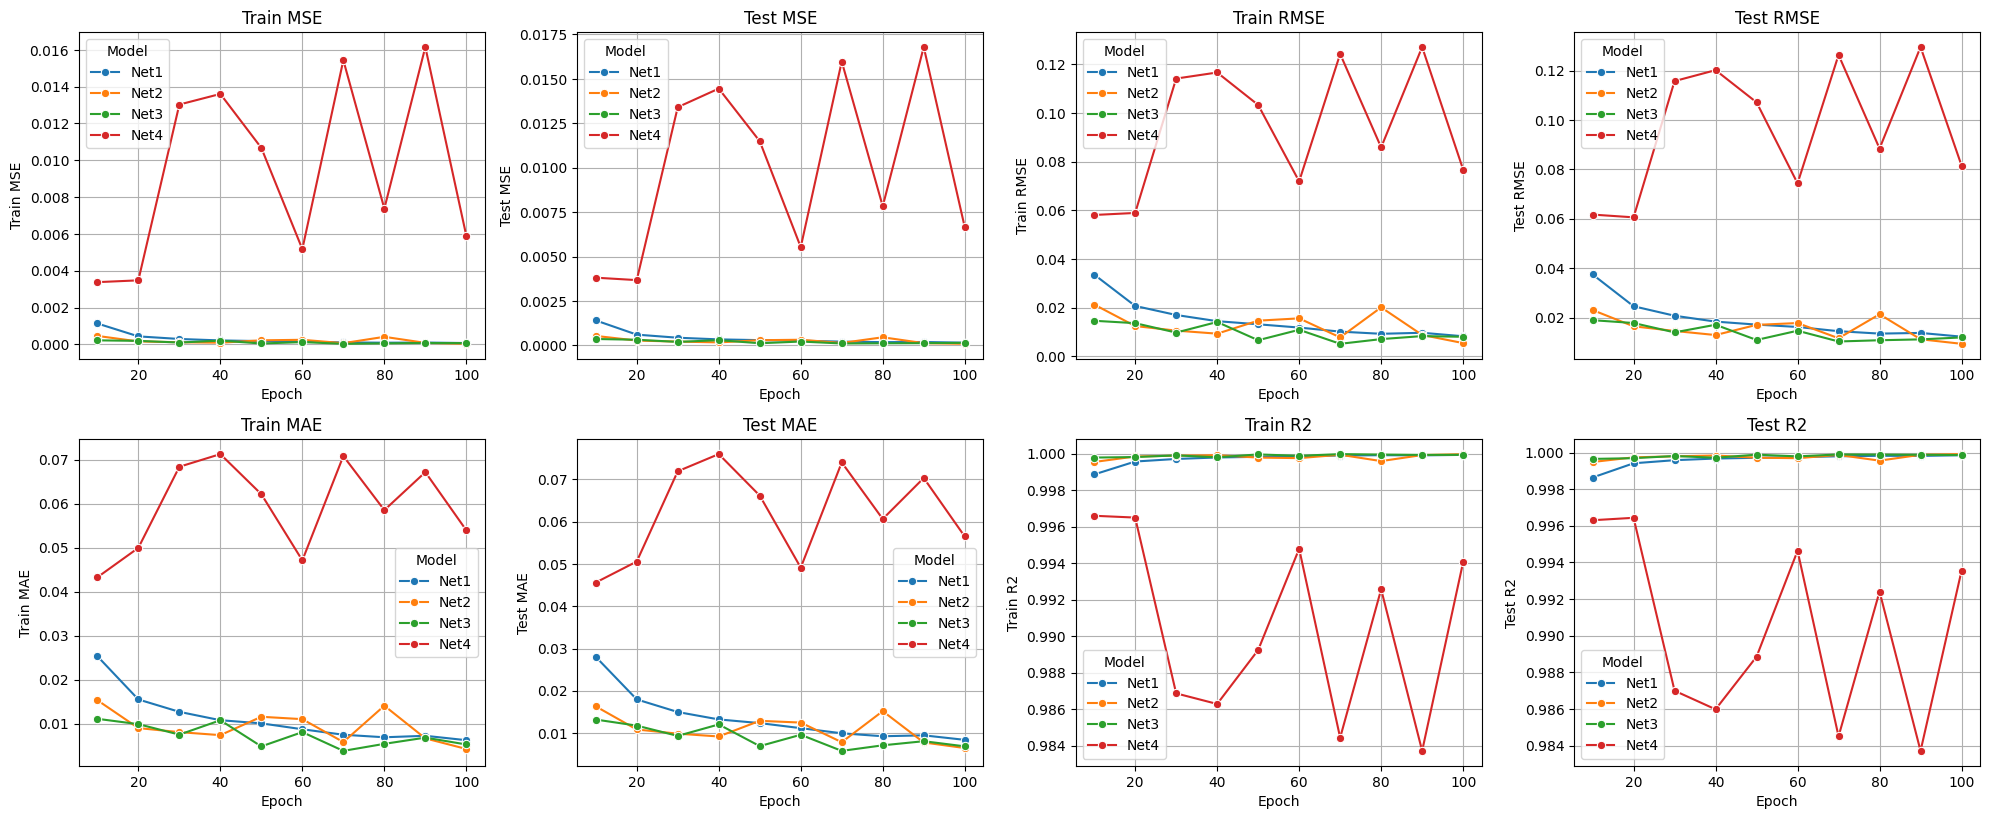

In [46]:
train_figures = {}
metrics_to_plot = ["Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
                   "Train MAE", "Test MAE", "Train R2", "Test R2"]

plt.figure(figsize=(20, 16))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 4, i)
    sns.lineplot(data=nn_metrics_df, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title(metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)

plt.tight_layout()
fig = plt.gcf()
train_figures["Train_Metrics_Nets"] = fig
plt.show()
plt.close()

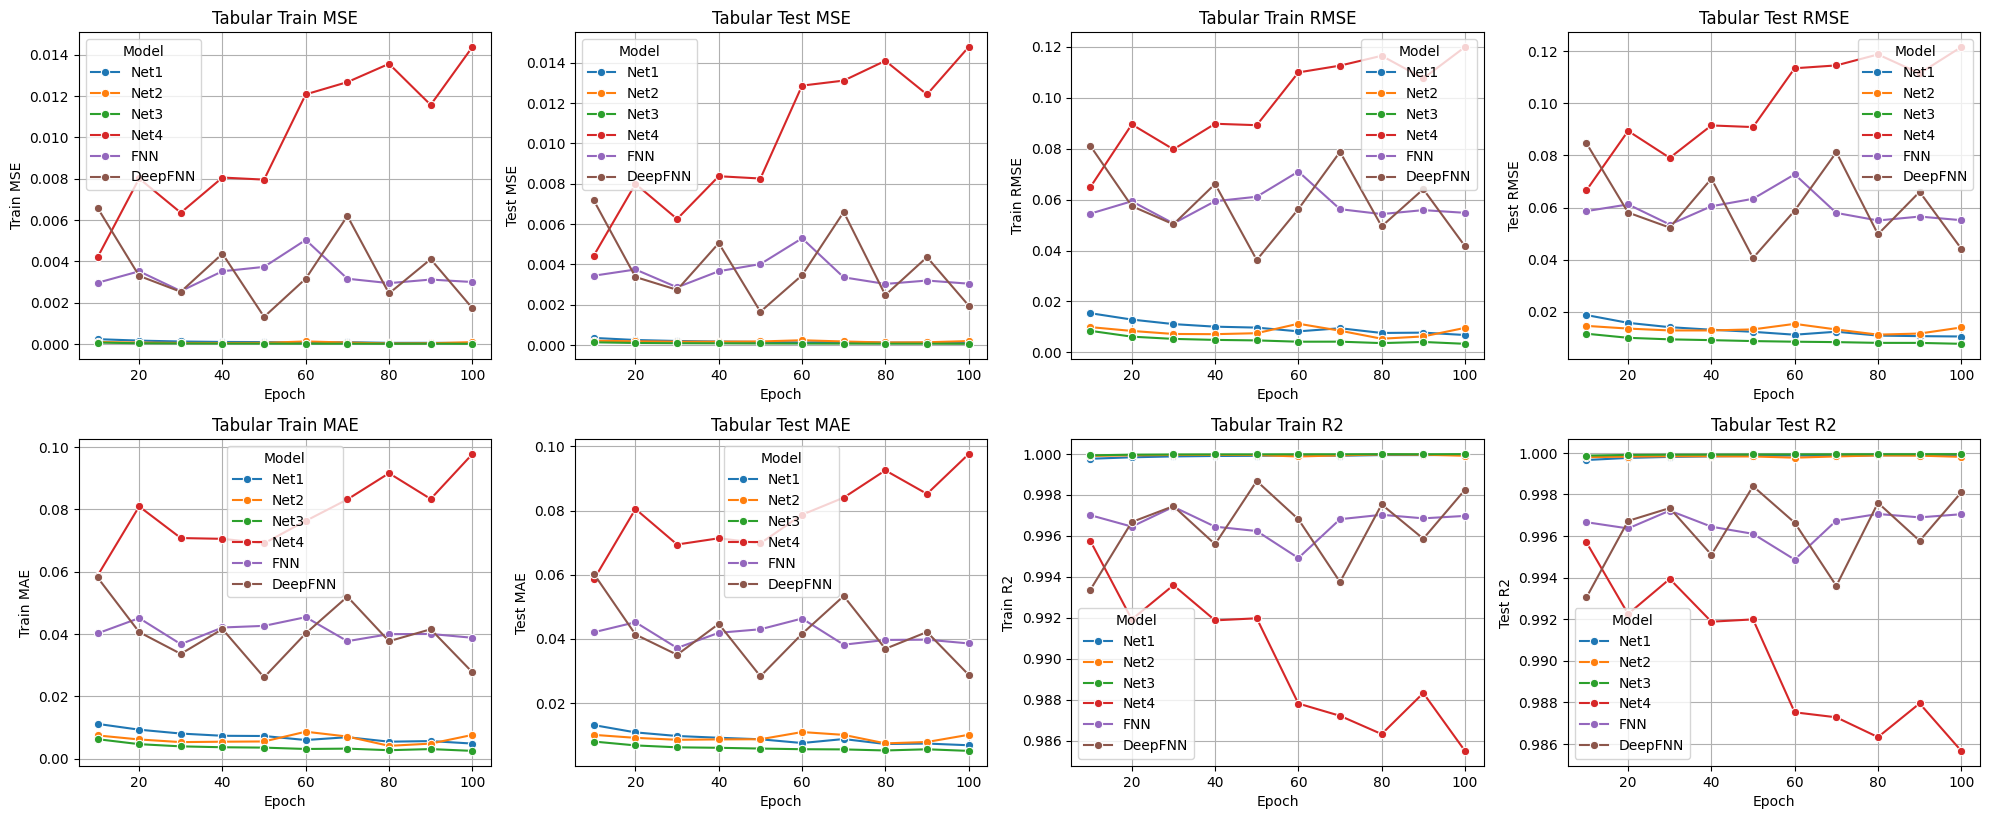

In [47]:
train_figures_tabular = {}

plt.figure(figsize=(20, 16))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 4, i)
    sns.lineplot(data=nn_metrics_df_tabular, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title("Tabular " + metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)

plt.tight_layout()
fig = plt.gcf()
train_figures_tabular["Train_Metrics_Tabular"] = fig
plt.show()
plt.close()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values,         
    y.values,        
    test_size=0.2,
    shuffle=False
)

scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

y_mean, y_std    = y_train.mean(), y_train.std()
y_train_norm     = (y_train - y_mean) / y_std
y_test_norm      = (y_test  - y_mean) / y_std

def create_sequence_data(X_arr, y_arr, seq_len=5):
    Xs, ys = [], []
    for i in range(len(X_arr) - seq_len):
        Xs.append(X_arr[i : i + seq_len])
        ys.append(y_arr[i + seq_len])
    return np.stack(Xs), np.stack(ys)

seq_len = 5
X_train_seq, y_train_seq = create_sequence_data(X_train_scaled, y_train_norm, seq_len)
X_test_seq,  y_test_seq  = create_sequence_data(X_test_scaled,  y_test_norm,  seq_len)

X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)  
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1)
X_test_seq_tensor  = torch.tensor(X_test_seq,  dtype=torch.float32)
y_test_seq_tensor  = torch.tensor(y_test_seq,  dtype=torch.float32).view(-1, 1)

train_loader_seq = DataLoader(
    TensorDataset(X_train_seq_tensor, y_train_seq_tensor),
    batch_size=64, shuffle=True
)
test_loader_seq  = DataLoader(
    TensorDataset(X_test_seq_tensor,  y_test_seq_tensor),
    batch_size=64, shuffle=False
)

In [24]:
in_channels = X_train_seq_tensor.shape[2]  

ts_nets = {
    "TCN":     TCN(in_channels, num_channels=[64,64]),
    "CNN1D":   CNN1D(in_channels, num_filters=32, num_layers=2, kernel_size=3, dropout=0.2),
    "GRUNet":  GRUNet(in_channels),
    "RNNNet":  RNNNet(in_channels),
    "CNNLSTM": CNNLSTM(in_channels),
    "BiLSTMNet":  BiLSTMNet(in_channels),
    "DeepLSTMNet":DeepLSTMNet(in_channels),
    "CNNBiLSTM":  CNNBiLSTM(in_channels),
    "GRUCNN":     GRUCNN(in_channels),
    "TCNLSTM":    TCNLSTM(in_channels),
    "Seq2SeqLSTM":Seq2SeqLSTM(in_channels),
}

In [25]:
results_ts = []
for name, net in ts_nets.items():
    results_ts += train_ts_model(
        name,
        net,
        train_loader_seq,       
        X_train_seq_tensor,     
        y_train_seq_tensor,     
        X_test_seq_tensor,      
        y_test_seq_tensor,      
        epochs=100,
        lr=1e-3
    )

nn_metrics_ts_df = pd.DataFrame(results_ts)

Training TCN: 100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.70s/it]



Model: TCN | Epoch: 100
Train: MSE: 0.0081, RMSE: 0.0900, MAE: 0.0551, R2: 0.9919
Test:  MSE: 0.0438, RMSE: 0.2092, MAE: 0.1794, R2: 0.9821


Training CNN1D: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.23it/s]



Model: CNN1D | Epoch: 100
Train: MSE: 0.0140, RMSE: 0.1183, MAE: 0.0690, R2: 0.9860
Test:  MSE: 0.0286, RMSE: 0.1691, MAE: 0.1245, R2: 0.9883


Training GRUNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.98it/s]



Model: GRUNet | Epoch: 100
Train: MSE: 0.0061, RMSE: 0.0780, MAE: 0.0431, R2: 0.9939
Test:  MSE: 0.1110, RMSE: 0.3331, MAE: 0.2364, R2: 0.9547


Training RNNNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.08it/s]



Model: RNNNet | Epoch: 100
Train: MSE: 0.0054, RMSE: 0.0737, MAE: 0.0433, R2: 0.9946
Test:  MSE: 0.1501, RMSE: 0.3875, MAE: 0.2751, R2: 0.9387


Training CNNLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [04:12<00:00,  2.52s/it]



Model: CNNLSTM | Epoch: 100
Train: MSE: 0.0181, RMSE: 0.1344, MAE: 0.0772, R2: 0.9820
Test:  MSE: 0.0478, RMSE: 0.2187, MAE: 0.1838, R2: 0.9805


Training BiLSTMNet: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.15it/s]



Model: BiLSTMNet | Epoch: 100
Train: MSE: 0.0068, RMSE: 0.0825, MAE: 0.0485, R2: 0.9932
Test:  MSE: 0.0896, RMSE: 0.2994, MAE: 0.2180, R2: 0.9634


Training DeepLSTMNet: 100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.47it/s]



Model: DeepLSTMNet | Epoch: 100
Train: MSE: 0.0075, RMSE: 0.0868, MAE: 0.0493, R2: 0.9925
Test:  MSE: 0.0468, RMSE: 0.2164, MAE: 0.1541, R2: 0.9809


Training CNNBiLSTM: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.94it/s]



Model: CNNBiLSTM | Epoch: 100
Train: MSE: 0.0100, RMSE: 0.1000, MAE: 0.0549, R2: 0.9900
Test:  MSE: 0.0567, RMSE: 0.2382, MAE: 0.1829, R2: 0.9768


Training GRUCNN: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.03it/s]



Model: GRUCNN | Epoch: 100
Train: MSE: 0.0099, RMSE: 0.0997, MAE: 0.0531, R2: 0.9901
Test:  MSE: 0.0954, RMSE: 0.3089, MAE: 0.2035, R2: 0.9611


Training TCNLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [03:01<00:00,  1.81s/it]



Model: TCNLSTM | Epoch: 100
Train: MSE: 0.0043, RMSE: 0.0657, MAE: 0.0380, R2: 0.9957
Test:  MSE: 0.0424, RMSE: 0.2059, MAE: 0.1705, R2: 0.9827


Training Seq2SeqLSTM: 100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.38it/s]


Model: Seq2SeqLSTM | Epoch: 100
Train: MSE: 0.0077, RMSE: 0.0879, MAE: 0.0518, R2: 0.9923
Test:  MSE: 0.1519, RMSE: 0.3898, MAE: 0.2621, R2: 0.9380


In [45]:
best_idx = nn_metrics_ts_df.groupby("Model")["Test R2"].idxmax()
best_results_ts = nn_metrics_ts_df.loc[best_idx].reset_index(drop=True)
best_results_ts = best_results_ts[cols]
best_results_ts

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0     BiLSTMNet     90   0.008668  0.077831    0.093100   0.278983   0.050999   
1         CNN1D    100   0.013985  0.028596    0.118256   0.169104   0.069043   
2     CNNBiLSTM     20   0.019712  0.018785    0.140398   0.137060   0.073474   
3       CNNLSTM     60   0.024111  0.029080    0.155279   0.170529   0.084973   
4   DeepLSTMNet     60   0.015019  0.024315    0.122553   0.155933   0.067616   
5        GRUCNN     50   0.018169  0.074524    0.134794   0.272990   0.076410   
6        GRUNet     80   0.007526  0.053015    0.086754   0.230251   0.047387   
7        RNNNet     10   0.015858  0.064217    0.125930   0.253411   0.071722   
8   Seq2SeqLSTM     70   0.009470  0.145391    0.097314   0.381301   0.055121   
9           TCN     50   0.009736  0.025589    0.098669   0.159965   0.053238   
10      TCNLSTM     20   0.014076  0.030116    0.118643   0.173539   0.067168   

    Test MAE  Train R2   Test R2  
0   0.224906  0.991344  0.968241  
1   0.124451  0.986034  0.988331  
2   0.111244  0.980315  0.992335  
3   0.125843  0.975920  0.988134  
4   0.106522  0.985001  0.990078  
5   0.189384  0.981855  0.969591  
6   0.178378  0.992484  0.978367  
7   0.202763  0.984163  0.973796  
8   0.256278  0.990543  0.940673  
9   0.135198  0.990277  0.989558  
10  0.136568  0.985942  0.987711

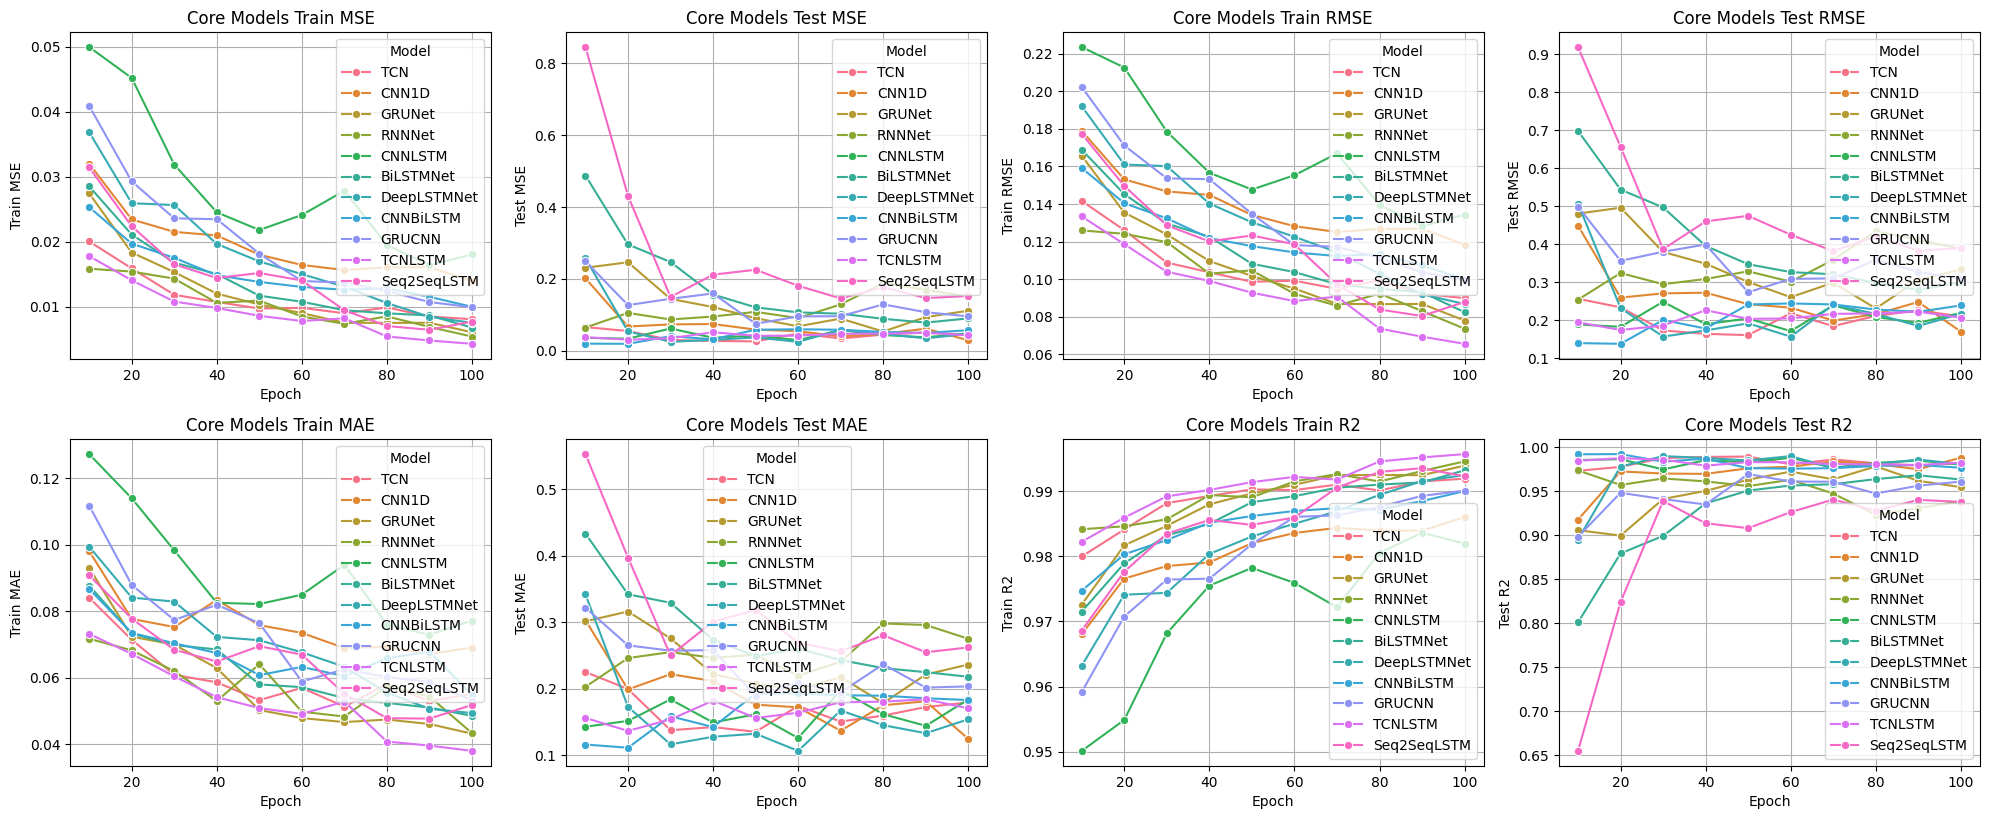

In [64]:
train_figures_ts = {}

models = ["TCN", "CNN1D", "GRUNet", "RNNNet", "CNNLSTM", "BiLSTMNet", "DeepLSTMNet", "CNNBiLSTM", "GRUCNN", "TCNLSTM", "Seq2SeqLSTM"]
df_models = nn_metrics_ts_df[nn_metrics_ts_df["Model"].isin(models)]

plt.figure(figsize=(20, 16))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 4, i)
    sns.lineplot(data=df_models, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title("Core Models " + metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)
plt.tight_layout()
fig = plt.gcf()
train_figures_ts["Train_Metrics_TS"] = fig
plt.show()
plt.close()

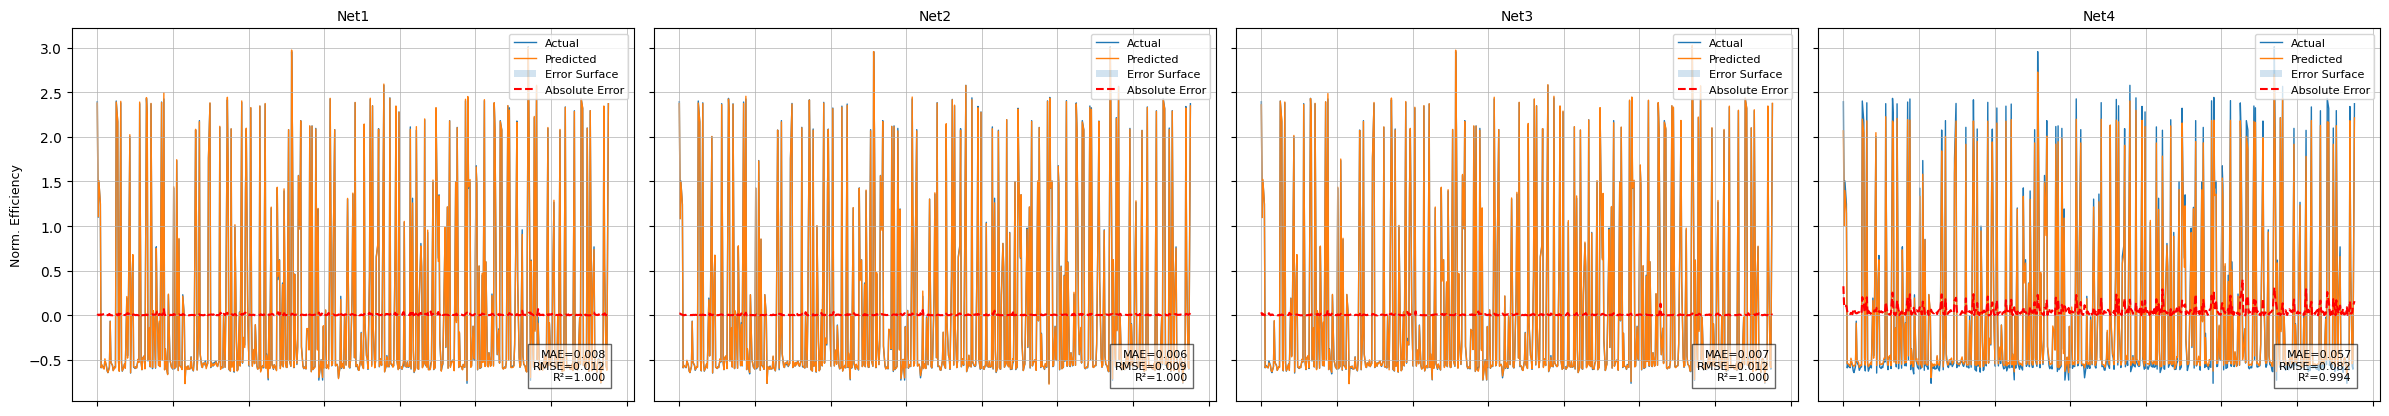

In [49]:
pred_figures_nets = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_models = len(nets)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16),
                         sharex=True, sharey=True)
axes = axes.flatten()

desired = 2500   
max_pts = 500     

for i, (name, model) in enumerate(nets.items()):
    ax = axes[i]
    model = model.to(device).eval()

    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)

    idx = np.linspace(0, n_samples - 1,
                      min(n_samples, max_pts),
                      dtype=int)

    ax.plot(idx, y_t[idx],   label="Actual",    lw=1, zorder=1)
    ax.plot(idx, y_p[idx],   label="Predicted", lw=1, zorder=1)

    ax.fill_between(idx, y_t[idx], y_p[idx],
                    alpha=0.2, label="Error Surface", zorder=0)
    
    ax.plot(idx, err[idx],
            '--', lw=1.5, color='red',
            label="Absolute Error", zorder=3)

    m = (nn_metrics_df
         .query("Model == @name")
         .sort_values("Epoch")
         .iloc[-1])
    stats = (
        f"MAE={m['Test MAE']:.3f}\n"
        f"RMSE={m['Test RMSE']:.3f}\n"
        f"R²={m['Test R2']:.3f}"
    )
    ax.text(.95, .05, stats,
            transform=ax.transAxes,
            ha='right', va='bottom',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if i % ncols == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if i // ncols == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper right")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets["Prediction_Nets"] = fig
plt.show()
plt.close()

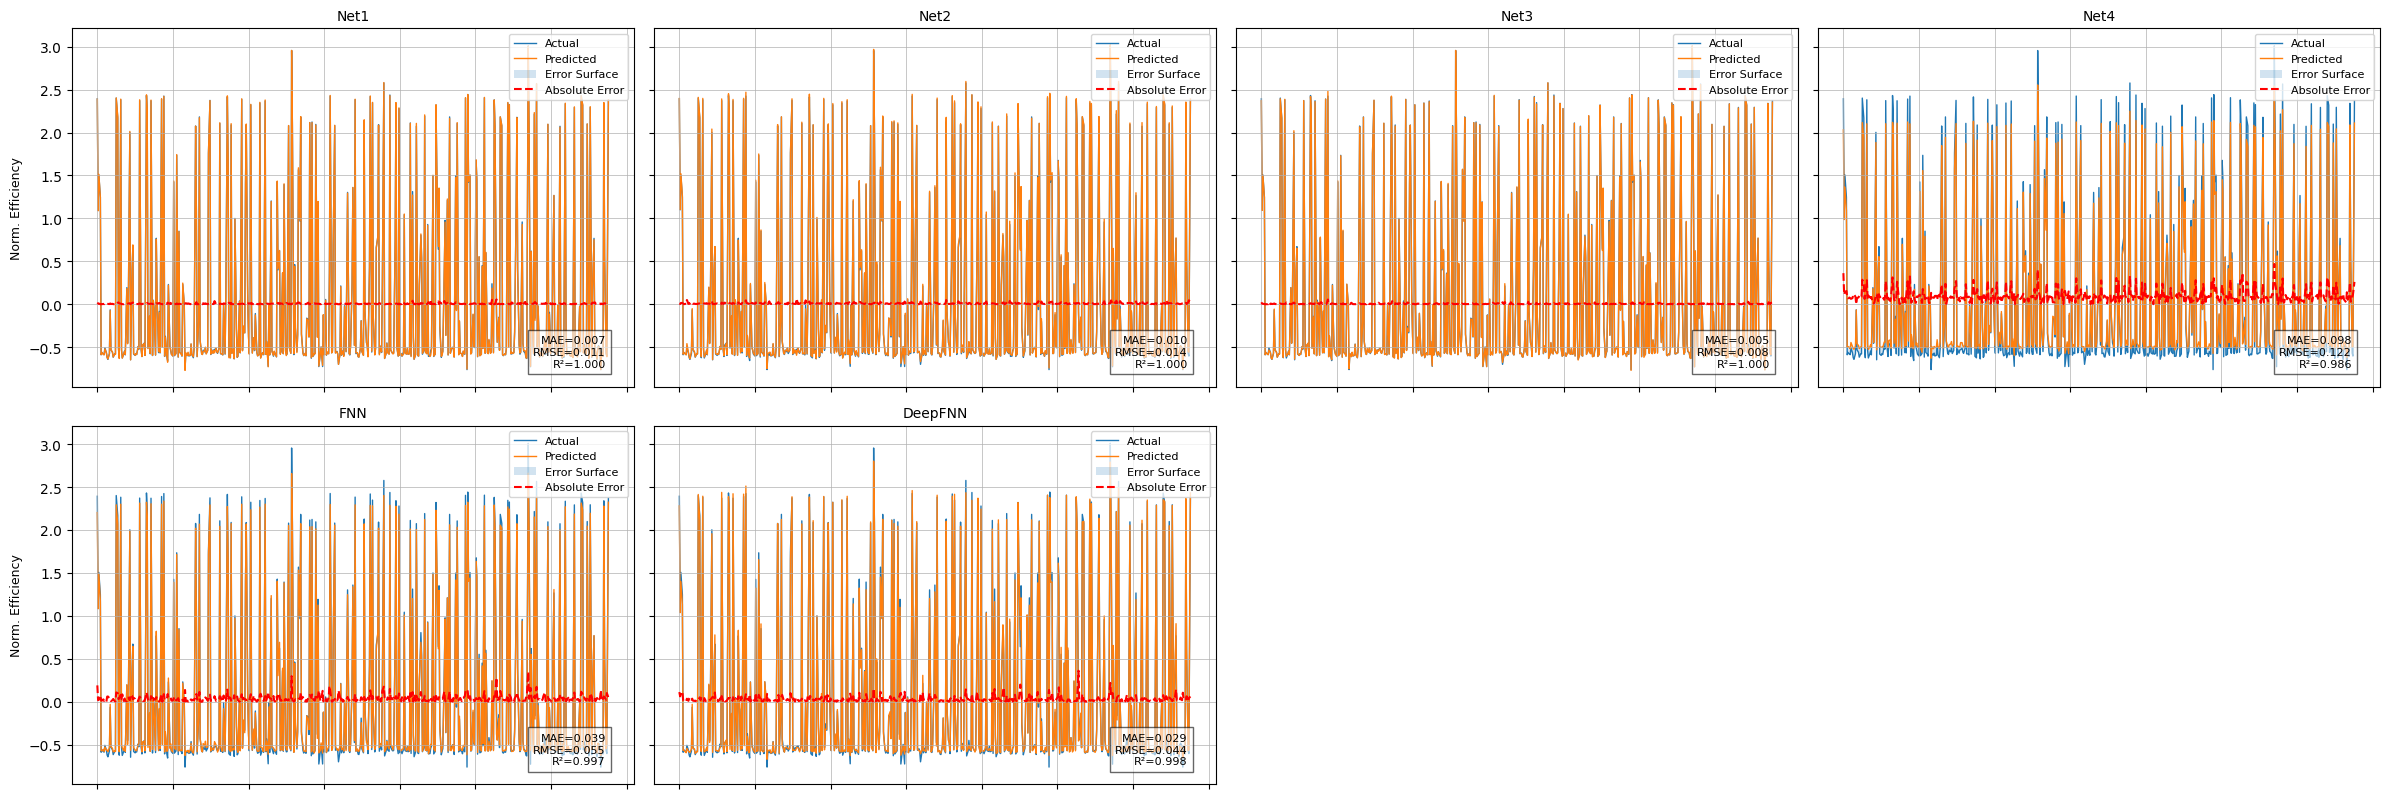

In [50]:
pred_figures_nets_tab = {}

n_models = len(nets_tabular)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16),
                         sharex=True, sharey=True)
axes = axes.flatten()

desired = 2500   
max_pts = 500     

for i, (name, model) in enumerate(nets_tabular.items()):
    ax = axes[i]
    model = model.to(device).eval()

    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)

    idx = np.linspace(0, n_samples - 1,
                      min(n_samples, max_pts),
                      dtype=int)

    ax.plot(idx, y_t[idx],   label="Actual",    lw=1, zorder=1)
    ax.plot(idx, y_p[idx],   label="Predicted", lw=1, zorder=1)

    ax.fill_between(idx, y_t[idx], y_p[idx],
                    alpha=0.2, label="Error Surface", zorder=0)
    
    ax.plot(idx, err[idx],
            '--', lw=1.5, color='red',
            label="Absolute Error", zorder=3)

    m = (nn_metrics_df_tabular
         .query("Model == @name")
         .sort_values("Epoch")
         .iloc[-1])
    stats = (
        f"MAE={m['Test MAE']:.3f}\n"
        f"RMSE={m['Test RMSE']:.3f}\n"
        f"R²={m['Test R2']:.3f}"
    )
    ax.text(.95, .05, stats,
            transform=ax.transAxes,
            ha='right', va='bottom',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if i % ncols == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if i // ncols == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper right")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets_tab["Prediction_Nets_Tab"] = fig
plt.show()
plt.close()

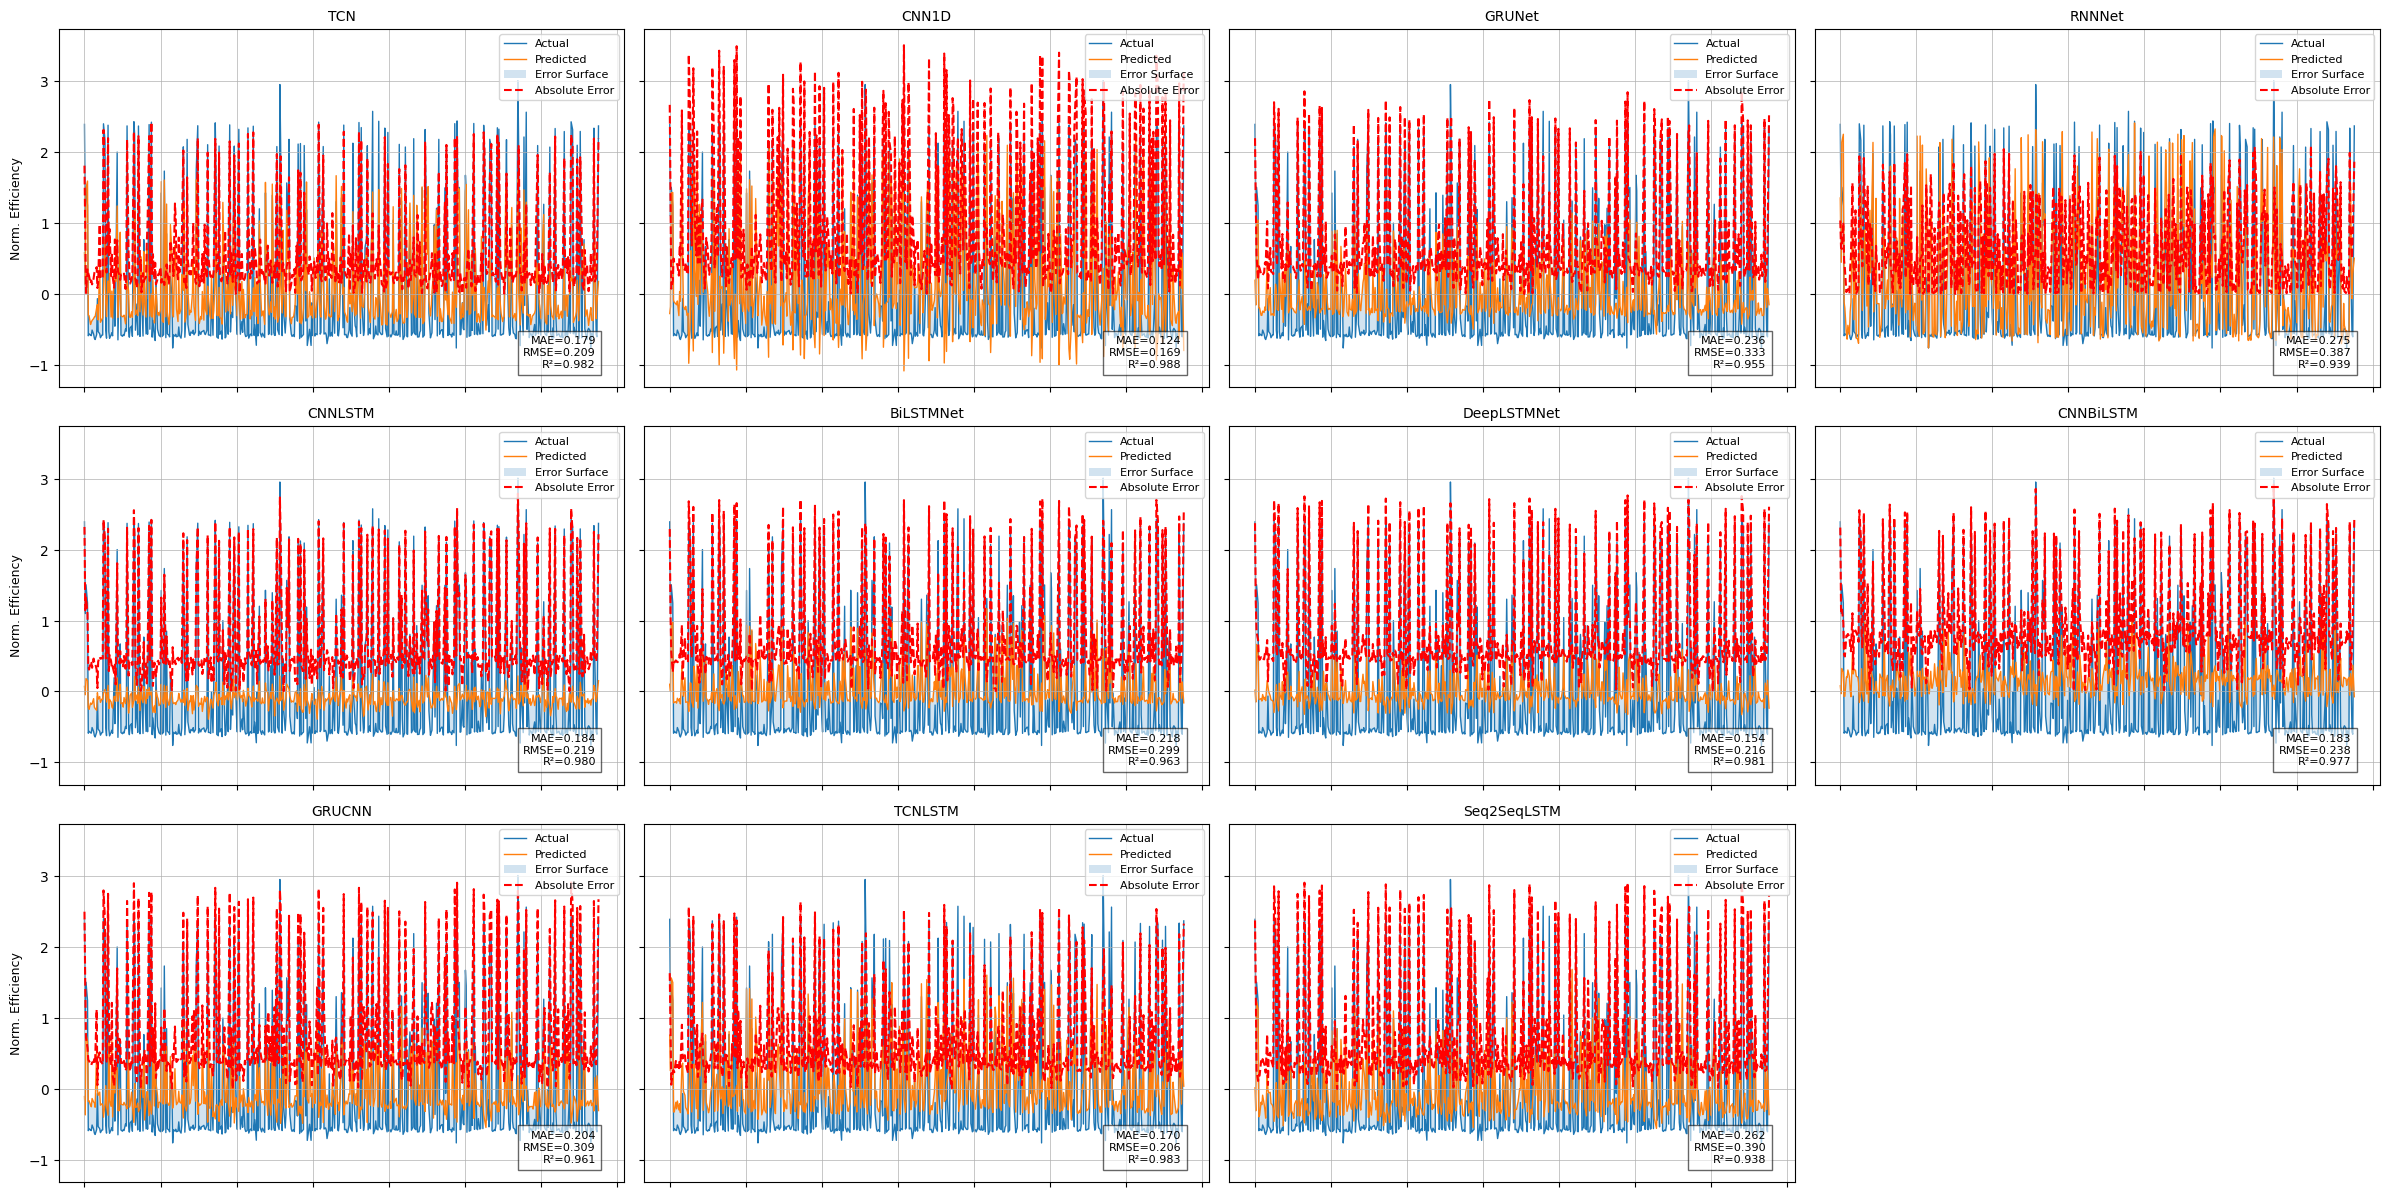

In [51]:
pred_figures_nets_ts = {}

n_models = len(ts_nets)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16),
                         sharex=True, sharey=True)
axes = axes.flatten()

desired = 2500   
max_pts = 500     

for i, (name, model) in enumerate(ts_nets.items()):
    ax = axes[i]
    model = model.to(device).eval()

    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)

    idx = np.linspace(0, n_samples - 1,
                      min(n_samples, max_pts),
                      dtype=int)

    ax.plot(idx, y_t[idx],   label="Actual",    lw=1, zorder=1)
    ax.plot(idx, y_p[idx],   label="Predicted", lw=1, zorder=1)

    ax.fill_between(idx, y_t[idx], y_p[idx],
                    alpha=0.2, label="Error Surface", zorder=0)
    
    ax.plot(idx, err[idx],
            '--', lw=1.5, color='red',
            label="Absolute Error", zorder=3)

    m = (nn_metrics_ts_df
         .query("Model == @name")
         .sort_values("Epoch")
         .iloc[-1])
    stats = (
        f"MAE={m['Test MAE']:.3f}\n"
        f"RMSE={m['Test RMSE']:.3f}\n"
        f"R²={m['Test R2']:.3f}"
    )
    ax.text(.95, .05, stats,
            transform=ax.transAxes,
            ha='right', va='bottom',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if i % ncols == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if i // ncols == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper right")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets_ts["Prediction_Nets_TS"] = fig
plt.show()
plt.close()

In [57]:
for name, model in nets.items():
    save_experiment(
        station="Amberd2",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df[nn_metrics_df["Model"] == name],
        train_figs={"Train_Metrics": train_figures["Train_Metrics_Nets"]},
        pred_figs={"Predictions": pred_figures_nets["Prediction_Nets"]},
        base_dir=Path("..")
    )

In [58]:
for name, model in nets_tabular.items():
    save_experiment(
        station="Amberd2",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df_tabular[nn_metrics_df_tabular["Model"] == name],
        train_figs={"Train_Metrics": train_figures_tabular["Train_Metrics_Tabular"]},
        pred_figs={"Predictions": pred_figures_nets_tab["Prediction_Nets_Tab"]},
        base_dir=Path("..")
    )

In [59]:
for name, model in ts_nets.items():
    save_experiment(
        station="Amberd2",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_ts_df[nn_metrics_ts_df["Model"] == name],
        train_figs={"Train_Metrics": train_figures_ts["Train_Metrics_TS"]},
        pred_figs={"Predictions": pred_figures_nets_ts["Prediction_Nets_TS"]},
        base_dir=Path("..")
    )